In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
torch.__version__, torch.cuda.is_available()

('1.4.0', True)

In [3]:
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

In [4]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

In [5]:
all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
all_marks

[{'nums': [{'box': [[180, 889], [596, 951], [598, 1056], [185, 983]],
    'text': 'B060BB125'}],
  'file': 'train/0.jpg'},
 {'nums': [{'box': [[794, 661], [1004, 618], [1009, 670], [799, 717]],
    'text': 'M938OX116'},
   {'box': [[944, 268], [995, 267], [994, 283], [942, 283]],
    'text': 'H881OA116'}],
  'file': 'train/1.jpg'},
 {'nums': [{'box': [[286, 603], [346, 606], [346, 621], [285, 616]],
    'text': 'A549XA163'}],
  'file': 'train/2.jpg'},
 {'nums': [{'box': [[217, 486], [489, 487], [488, 580], [204, 570]],
    'text': 'O934MO190'}],
  'file': 'train/3.jpg'},
 {'nums': [{'box': [[115, 184], [202, 168], [204, 189], [119, 207]],
    'text': 'T647TO35'}],
  'file': 'train/4.bmp'},
 {'nums': [{'box': [[153, 318], [262, 339], [264, 371], [155, 348]],
    'text': 'A750PY35'}],
  'file': 'train/5.bmp'},
 {'nums': [{'box': [[340, 1138], [687, 1176], [703, 1279], [352, 1229]],
    'text': 'C154TY98'}],
  'file': 'train/6.jpg'},
 {'nums': [{'box': [[257, 269], [439, 267], [440, 307],

## Dataset for detection

In [6]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.marks)

In [7]:
transforms_ = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=transforms_
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=transforms_
)

### Dataloader for detection

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn
)

### Detection model

In [10]:
torch.cuda.empty_cache()
gc.collect()
model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
    
box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor = box_predictor

mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
model.roi_heads.mask_predictor = mask_predictor

model = model.to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

In [12]:
model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|▏                                                                            | 20/11534 [00:20<3:11:10,  1.00it/s]

Loss: 0.6686307


  0%|▎                                                                            | 40/11534 [00:42<3:11:32,  1.00it/s]

Loss: 0.3575787


  1%|▍                                                                            | 60/11534 [01:06<4:34:29,  1.44s/it]

Loss: 0.2493002


  1%|▌                                                                            | 80/11534 [01:29<3:34:08,  1.12s/it]

Loss: 0.2583236


  1%|▋                                                                           | 100/11534 [01:51<3:32:04,  1.11s/it]

Loss: 0.2479788


  1%|▊                                                                           | 120/11534 [02:11<3:28:05,  1.09s/it]

Loss: 0.2066772


  1%|▉                                                                           | 140/11534 [02:31<3:04:28,  1.03it/s]

Loss: 0.2283697


  1%|█                                                                           | 160/11534 [02:51<3:40:16,  1.16s/it]

Loss: 0.1975884


  2%|█▏                                                                          | 180/11534 [03:14<3:41:46,  1.17s/it]

Loss: 0.2237975


  2%|█▎                                                                          | 200/11534 [03:34<2:55:32,  1.08it/s]

Loss: 0.1934708


  2%|█▍                                                                          | 220/11534 [03:55<3:18:16,  1.05s/it]

Loss: 0.1708568


  2%|█▌                                                                          | 240/11534 [04:18<4:21:44,  1.39s/it]

Loss: 0.1821710


  2%|█▋                                                                          | 260/11534 [04:40<3:32:50,  1.13s/it]

Loss: 0.2130879


  2%|█▊                                                                          | 280/11534 [05:01<3:25:23,  1.09s/it]

Loss: 0.2202745


  3%|█▉                                                                          | 300/11534 [05:22<3:45:45,  1.21s/it]

Loss: 0.1646422


  3%|██                                                                          | 320/11534 [05:42<2:48:31,  1.11it/s]

Loss: 0.2141098


  3%|██▏                                                                         | 340/11534 [06:05<3:48:46,  1.23s/it]

Loss: 0.2041974


  3%|██▎                                                                         | 360/11534 [06:28<3:28:03,  1.12s/it]

Loss: 0.2019366


  3%|██▌                                                                         | 380/11534 [06:49<3:18:55,  1.07s/it]

Loss: 0.1768205


  3%|██▋                                                                         | 400/11534 [07:10<3:08:48,  1.02s/it]

Loss: 0.1734375


  4%|██▊                                                                         | 420/11534 [07:31<3:02:02,  1.02it/s]

Loss: 0.1852104


  4%|██▉                                                                         | 440/11534 [07:51<3:22:03,  1.09s/it]

Loss: 0.2254796


  4%|███                                                                         | 460/11534 [08:14<4:01:33,  1.31s/it]

Loss: 0.1814154


  4%|███▏                                                                        | 480/11534 [08:35<3:07:47,  1.02s/it]

Loss: 0.2760919


  4%|███▎                                                                        | 500/11534 [08:56<3:02:32,  1.01it/s]

Loss: 0.2664519


  5%|███▍                                                                        | 520/11534 [09:15<2:46:36,  1.10it/s]

Loss: 0.2514137


  5%|███▌                                                                        | 540/11534 [09:37<3:21:33,  1.10s/it]

Loss: 0.2391639


  5%|███▋                                                                        | 560/11534 [09:59<2:58:37,  1.02it/s]

Loss: 0.2514905


  5%|███▊                                                                        | 580/11534 [10:19<2:52:29,  1.06it/s]

Loss: 0.2458331


  5%|███▉                                                                        | 600/11534 [10:41<3:16:03,  1.08s/it]

Loss: 0.1812076


  5%|████                                                                        | 620/11534 [11:00<2:50:28,  1.07it/s]

Loss: 0.1874947


  6%|████▏                                                                       | 640/11534 [11:21<3:10:01,  1.05s/it]

Loss: 0.2115698


  6%|████▎                                                                       | 660/11534 [11:44<3:49:08,  1.26s/it]

Loss: 0.1820552


  6%|████▍                                                                       | 680/11534 [12:04<2:42:36,  1.11it/s]

Loss: 0.1699724


  6%|████▌                                                                       | 700/11534 [12:24<2:39:41,  1.13it/s]

Loss: 0.1859708


  6%|████▋                                                                       | 720/11534 [12:44<3:19:20,  1.11s/it]

Loss: 0.1575794


  6%|████▉                                                                       | 740/11534 [13:06<3:22:51,  1.13s/it]

Loss: 0.1825305


  7%|█████                                                                       | 760/11534 [13:27<3:42:30,  1.24s/it]

Loss: 0.2058282


  7%|█████▏                                                                      | 780/11534 [13:47<2:47:57,  1.07it/s]

Loss: 0.1863368


  7%|█████▎                                                                      | 800/11534 [14:08<3:11:36,  1.07s/it]

Loss: 0.2000847


  7%|█████▍                                                                      | 820/11534 [14:30<2:49:08,  1.06it/s]

Loss: 0.2111252


  7%|█████▌                                                                      | 840/11534 [14:51<3:07:11,  1.05s/it]

Loss: 0.2006247


  7%|█████▋                                                                      | 860/11534 [15:12<3:10:32,  1.07s/it]

Loss: 0.1781503


  8%|█████▊                                                                      | 880/11534 [15:34<3:23:36,  1.15s/it]

Loss: 0.1886093


  8%|█████▉                                                                      | 900/11534 [15:54<3:02:01,  1.03s/it]

Loss: 0.1463127


  8%|██████                                                                      | 920/11534 [16:16<2:58:38,  1.01s/it]

Loss: 0.1890223


  8%|██████▏                                                                     | 940/11534 [16:35<2:48:46,  1.05it/s]

Loss: 0.1807181


  8%|██████▎                                                                     | 960/11534 [16:57<3:04:47,  1.05s/it]

Loss: 0.1954208


  8%|██████▍                                                                     | 980/11534 [17:19<2:38:58,  1.11it/s]

Loss: 0.1701300


  9%|██████▌                                                                    | 1000/11534 [17:41<3:36:58,  1.24s/it]

Loss: 0.1479786


  9%|██████▋                                                                    | 1020/11534 [18:03<3:18:49,  1.13s/it]

Loss: 0.1723387


  9%|██████▊                                                                    | 1040/11534 [18:27<4:12:19,  1.44s/it]

Loss: 0.1816411


  9%|██████▉                                                                    | 1060/11534 [18:46<2:43:52,  1.07it/s]

Loss: 0.1698809


  9%|███████                                                                    | 1080/11534 [19:07<3:03:14,  1.05s/it]

Loss: 0.1733733


 10%|███████▏                                                                   | 1100/11534 [19:27<2:43:17,  1.06it/s]

Loss: 0.1742103


 10%|███████▎                                                                   | 1120/11534 [19:49<2:43:09,  1.06it/s]

Loss: 0.1736241


 10%|███████▍                                                                   | 1140/11534 [20:13<2:54:58,  1.01s/it]

Loss: 0.1632382


 10%|███████▌                                                                   | 1160/11534 [20:34<3:08:36,  1.09s/it]

Loss: 0.1562020


 10%|███████▋                                                                   | 1180/11534 [20:56<3:15:11,  1.13s/it]

Loss: 0.1524017


 10%|███████▊                                                                   | 1200/11534 [21:18<3:10:06,  1.10s/it]

Loss: 0.1638795


 11%|███████▉                                                                   | 1220/11534 [21:38<3:26:08,  1.20s/it]

Loss: 0.1817074


 11%|████████                                                                   | 1240/11534 [21:58<3:12:28,  1.12s/it]

Loss: 0.1787534


 11%|████████▏                                                                  | 1260/11534 [22:20<3:22:53,  1.18s/it]

Loss: 0.1492061


 11%|████████▎                                                                  | 1280/11534 [22:42<3:49:39,  1.34s/it]

Loss: 0.1560946


 11%|████████▍                                                                  | 1300/11534 [23:03<2:34:06,  1.11it/s]

Loss: 0.1696640


 11%|████████▌                                                                  | 1320/11534 [23:26<3:05:11,  1.09s/it]

Loss: 0.1994589
Epoch    66: reducing learning rate of group 0 to 1.5000e-04.


 12%|████████▋                                                                  | 1340/11534 [23:49<2:53:53,  1.02s/it]

Loss: 0.1689085


 12%|████████▊                                                                  | 1360/11534 [24:11<2:57:47,  1.05s/it]

Loss: 0.1728147


 12%|████████▉                                                                  | 1380/11534 [24:31<2:31:05,  1.12it/s]

Loss: 0.1666375


 12%|█████████                                                                  | 1400/11534 [24:53<2:44:25,  1.03it/s]

Loss: 0.1477819


 12%|█████████▏                                                                 | 1420/11534 [25:12<2:43:41,  1.03it/s]

Loss: 0.1617607


 12%|█████████▎                                                                 | 1440/11534 [25:34<3:23:43,  1.21s/it]

Loss: 0.1627280


 13%|█████████▍                                                                 | 1460/11534 [25:55<2:47:57,  1.00s/it]

Loss: 0.1719381


 13%|█████████▌                                                                 | 1480/11534 [26:16<2:50:41,  1.02s/it]

Loss: 0.1661927


 13%|█████████▊                                                                 | 1500/11534 [26:37<3:01:46,  1.09s/it]

Loss: 0.1638036


 13%|█████████▉                                                                 | 1520/11534 [26:57<2:47:48,  1.01s/it]

Loss: 0.1351377


 13%|██████████                                                                 | 1540/11534 [27:17<2:43:15,  1.02it/s]

Loss: 0.1608113


 14%|██████████▏                                                                | 1560/11534 [27:40<2:55:47,  1.06s/it]

Loss: 0.1944715


 14%|██████████▎                                                                | 1580/11534 [28:02<2:59:10,  1.08s/it]

Loss: 0.1419196


 14%|██████████▍                                                                | 1600/11534 [28:23<3:13:36,  1.17s/it]

Loss: 0.1539819


 14%|██████████▌                                                                | 1620/11534 [28:42<2:34:45,  1.07it/s]

Loss: 0.1370943


 14%|██████████▋                                                                | 1640/11534 [29:02<2:47:21,  1.01s/it]

Loss: 0.1505007


 14%|██████████▊                                                                | 1660/11534 [29:24<2:40:01,  1.03it/s]

Loss: 0.1721479


 15%|██████████▉                                                                | 1680/11534 [29:46<2:48:43,  1.03s/it]

Loss: 0.1515182


 15%|███████████                                                                | 1700/11534 [30:07<3:13:22,  1.18s/it]

Loss: 0.1989468


 15%|███████████▏                                                               | 1720/11534 [30:30<3:33:44,  1.31s/it]

Loss: 0.1553706


 15%|███████████▎                                                               | 1740/11534 [30:51<2:39:36,  1.02it/s]

Loss: 0.1953873


 15%|███████████▍                                                               | 1760/11534 [31:12<2:36:33,  1.04it/s]

Loss: 0.1964074


 15%|███████████▌                                                               | 1780/11534 [31:33<2:45:03,  1.02s/it]

Loss: 0.1677893


 16%|███████████▋                                                               | 1800/11534 [31:55<2:27:52,  1.10it/s]

Loss: 0.1322919


 16%|███████████▊                                                               | 1820/11534 [32:16<3:30:03,  1.30s/it]

Loss: 0.1603183


 16%|███████████▉                                                               | 1840/11534 [32:36<2:42:04,  1.00s/it]

Loss: 0.1413952


 16%|████████████                                                               | 1860/11534 [33:00<3:00:39,  1.12s/it]

Loss: 0.1637599


 16%|████████████▏                                                              | 1880/11534 [33:24<3:06:23,  1.16s/it]

Loss: 0.1604558


 16%|████████████▎                                                              | 1900/11534 [33:44<2:21:11,  1.14it/s]

Loss: 0.1420789


 17%|████████████▍                                                              | 1920/11534 [34:06<3:17:31,  1.23s/it]

Loss: 0.1916386


 17%|████████████▌                                                              | 1940/11534 [34:26<2:26:40,  1.09it/s]

Loss: 0.1600884


 17%|████████████▋                                                              | 1960/11534 [34:46<2:34:46,  1.03it/s]

Loss: 0.1883729


 17%|████████████▊                                                              | 1980/11534 [35:10<3:06:46,  1.17s/it]

Loss: 0.1489179


 17%|█████████████                                                              | 2000/11534 [35:32<2:34:32,  1.03it/s]

Loss: 0.1513294


 18%|█████████████▏                                                             | 2020/11534 [35:53<2:41:43,  1.02s/it]

Loss: 0.1501114


 18%|█████████████▎                                                             | 2040/11534 [36:15<2:47:28,  1.06s/it]

Loss: 0.1327598


 18%|█████████████▍                                                             | 2060/11534 [36:37<2:36:28,  1.01it/s]

Loss: 0.1409633


 18%|█████████████▌                                                             | 2080/11534 [36:57<2:39:59,  1.02s/it]

Loss: 0.1811947


 18%|█████████████▋                                                             | 2100/11534 [37:19<2:51:58,  1.09s/it]

Loss: 0.2038326


 18%|█████████████▊                                                             | 2120/11534 [37:40<2:47:02,  1.06s/it]

Loss: 0.1695313


 19%|█████████████▉                                                             | 2140/11534 [38:03<3:01:35,  1.16s/it]

Loss: 0.1859579


 19%|██████████████                                                             | 2160/11534 [38:23<2:58:49,  1.14s/it]

Loss: 0.1418342


 19%|██████████████▏                                                            | 2180/11534 [38:44<2:46:12,  1.07s/it]

Loss: 0.1655544


 19%|██████████████▎                                                            | 2200/11534 [39:05<2:46:11,  1.07s/it]

Loss: 0.1900637


 19%|██████████████▍                                                            | 2220/11534 [39:25<2:36:04,  1.01s/it]

Loss: 0.1624967
Epoch   111: reducing learning rate of group 0 to 7.5000e-05.


 19%|██████████████▌                                                            | 2240/11534 [39:46<2:54:49,  1.13s/it]

Loss: 0.1498741


 20%|██████████████▋                                                            | 2260/11534 [40:07<2:20:23,  1.10it/s]

Loss: 0.1628676


 20%|██████████████▊                                                            | 2280/11534 [40:28<2:54:34,  1.13s/it]

Loss: 0.1729861


 20%|██████████████▉                                                            | 2300/11534 [40:50<2:37:23,  1.02s/it]

Loss: 0.1523427


 20%|███████████████                                                            | 2320/11534 [41:12<2:47:36,  1.09s/it]

Loss: 0.1442506


 20%|███████████████▏                                                           | 2340/11534 [41:32<2:36:54,  1.02s/it]

Loss: 0.1723576


 20%|███████████████▎                                                           | 2360/11534 [41:55<2:23:16,  1.07it/s]

Loss: 0.1491757


 21%|███████████████▍                                                           | 2380/11534 [42:17<2:55:38,  1.15s/it]

Loss: 0.1471102


 21%|███████████████▌                                                           | 2400/11534 [42:37<2:32:32,  1.00s/it]

Loss: 0.1481276


 21%|███████████████▋                                                           | 2404/11534 [42:42<2:55:11,  1.15s/it]

KeyboardInterrupt: 

In [13]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [14]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [15]:
model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))

<All keys matched successfully>

In [16]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

In [17]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = transforms_(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out

Class: plate, Confidence: 0.9996931552886963
Bounding box:


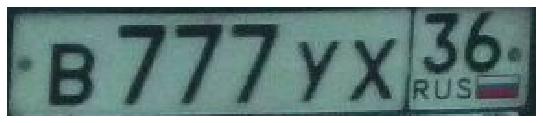

Rotated img:


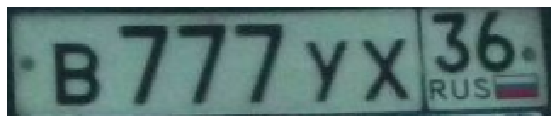

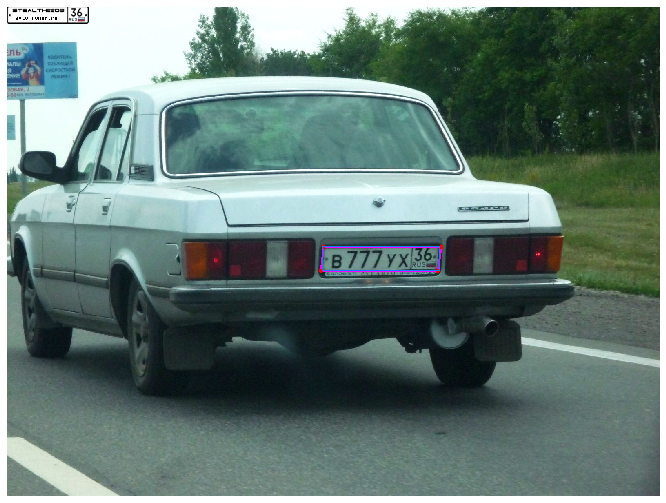

{'boxes': tensor([[ 773.6044,  589.3763, 1060.5381,  648.9609]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9997], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [18]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

In [20]:
THRESHOLD_SCORE = 0.90
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):
    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    #img = Image.open(file)
    img_tensor = transforms_(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            #_,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   


In [21]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

In [22]:
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls = NumpyEncoder)

### Dataset for recognition

In [23]:
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img

In [24]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)

    
ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=ocr_transforms
)

### DataLoaders for recognition

In [28]:
def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

74

In [46]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [47]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [48]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [49]:
crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|▌                                                                               | 20/3016 [00:06<16:31,  3.02it/s]

Loss: 5.8435168


  1%|█                                                                               | 40/3016 [00:13<16:44,  2.96it/s]

Loss: 3.7021560


  2%|█▌                                                                              | 60/3016 [00:19<17:22,  2.83it/s]

Loss: 3.4337643


  3%|██                                                                              | 80/3016 [00:26<16:52,  2.90it/s]

Loss: 3.3364814


  3%|██▌                                                                            | 100/3016 [00:33<16:43,  2.91it/s]

Loss: 3.2608814


  4%|███▏                                                                           | 120/3016 [00:40<15:29,  3.12it/s]

Loss: 3.2005340


  5%|███▋                                                                           | 140/3016 [00:46<15:41,  3.06it/s]

Loss: 3.1441753


  5%|████▏                                                                          | 160/3016 [00:54<17:44,  2.68it/s]

Loss: 3.0856685


  6%|████▋                                                                          | 180/3016 [01:02<18:41,  2.53it/s]

Loss: 3.0340319


  7%|█████▏                                                                         | 200/3016 [01:09<15:58,  2.94it/s]

Loss: 3.0095203


  7%|█████▊                                                                         | 220/3016 [01:16<16:06,  2.89it/s]

Loss: 2.9399774


  8%|██████▎                                                                        | 240/3016 [01:23<17:57,  2.58it/s]

Loss: 2.8966997


  9%|██████▊                                                                        | 260/3016 [01:30<15:58,  2.88it/s]

Loss: 2.8480183


  9%|███████▎                                                                       | 280/3016 [01:37<18:31,  2.46it/s]

Loss: 2.8054577


 10%|███████▊                                                                       | 300/3016 [01:45<18:19,  2.47it/s]

Loss: 2.7747151


 11%|████████▍                                                                      | 320/3016 [01:52<15:05,  2.98it/s]

Loss: 2.7246559


 11%|████████▉                                                                      | 340/3016 [01:59<16:29,  2.70it/s]

Loss: 2.6673522


 12%|█████████▍                                                                     | 360/3016 [02:07<15:21,  2.88it/s]

Loss: 2.5310332


 13%|█████████▉                                                                     | 380/3016 [02:14<15:26,  2.85it/s]

Loss: 2.5194557


 13%|██████████▍                                                                    | 400/3016 [02:21<14:24,  3.03it/s]

Loss: 2.4545051


 14%|███████████                                                                    | 420/3016 [02:28<14:55,  2.90it/s]

Loss: 2.3589163


 15%|███████████▌                                                                   | 440/3016 [02:35<16:51,  2.55it/s]

Loss: 2.2872156


 15%|████████████                                                                   | 460/3016 [02:42<13:42,  3.11it/s]

Loss: 2.2300181


 16%|████████████▌                                                                  | 480/3016 [02:49<16:54,  2.50it/s]

Loss: 2.1707628


 17%|█████████████                                                                  | 500/3016 [02:56<14:31,  2.89it/s]

Loss: 2.0687632


 17%|█████████████▌                                                                 | 520/3016 [03:03<16:06,  2.58it/s]

Loss: 2.0351648


 18%|██████████████▏                                                                | 540/3016 [03:11<15:34,  2.65it/s]

Loss: 2.0277221


 19%|██████████████▋                                                                | 560/3016 [03:18<15:24,  2.66it/s]

Loss: 1.9427421


 19%|███████████████▏                                                               | 580/3016 [03:25<13:03,  3.11it/s]

Loss: 1.8796541


 20%|███████████████▋                                                               | 600/3016 [03:32<14:30,  2.78it/s]

Loss: 1.7890684


 21%|████████████████▏                                                              | 620/3016 [03:39<13:13,  3.02it/s]

Loss: 1.7593416


 21%|████████████████▊                                                              | 640/3016 [03:46<13:04,  3.03it/s]

Loss: 1.7150335


 22%|█████████████████▎                                                             | 660/3016 [03:53<13:49,  2.84it/s]

Loss: 1.6607207


 23%|█████████████████▊                                                             | 680/3016 [04:00<13:19,  2.92it/s]

Loss: 1.5817136


 23%|██████████████████▎                                                            | 700/3016 [04:07<12:38,  3.05it/s]

Loss: 1.4954131


 24%|██████████████████▊                                                            | 720/3016 [04:14<15:01,  2.55it/s]

Loss: 1.4020307


 25%|███████████████████▍                                                           | 740/3016 [04:22<13:43,  2.76it/s]

Loss: 1.3354396


 25%|███████████████████▉                                                           | 760/3016 [04:29<14:02,  2.68it/s]

Loss: 1.3072940


 26%|████████████████████▍                                                          | 780/3016 [04:36<15:31,  2.40it/s]

Loss: 1.1800728


 27%|████████████████████▉                                                          | 800/3016 [04:43<12:24,  2.98it/s]

Loss: 1.0612269


 27%|█████████████████████▍                                                         | 820/3016 [04:51<14:01,  2.61it/s]

Loss: 1.0713251


 28%|██████████████████████                                                         | 840/3016 [04:58<12:56,  2.80it/s]

Loss: 0.9379686


 29%|██████████████████████▌                                                        | 860/3016 [05:05<13:10,  2.73it/s]

Loss: 0.9195149


 29%|███████████████████████                                                        | 880/3016 [05:12<12:48,  2.78it/s]

Loss: 0.8826388


 30%|███████████████████████▌                                                       | 900/3016 [05:20<12:41,  2.78it/s]

Loss: 0.8575400


 31%|████████████████████████                                                       | 920/3016 [05:27<12:13,  2.86it/s]

Loss: 0.8450621


 31%|████████████████████████▌                                                      | 940/3016 [05:34<12:45,  2.71it/s]

Loss: 0.7872426


 32%|█████████████████████████▏                                                     | 960/3016 [05:41<11:10,  3.07it/s]

Loss: 0.7362401


 32%|█████████████████████████▋                                                     | 980/3016 [05:48<11:49,  2.87it/s]

Loss: 0.6763756


 33%|█████████████████████████▊                                                    | 1000/3016 [05:55<11:56,  2.81it/s]

Loss: 0.6528519


 34%|██████████████████████████▍                                                   | 1020/3016 [06:03<12:38,  2.63it/s]

Loss: 0.6449042


 34%|██████████████████████████▉                                                   | 1040/3016 [06:10<11:51,  2.78it/s]

Loss: 0.6488111


 35%|███████████████████████████▍                                                  | 1060/3016 [06:17<12:00,  2.71it/s]

Loss: 0.5930128


 36%|███████████████████████████▉                                                  | 1080/3016 [06:24<11:32,  2.80it/s]

Loss: 0.5537750


 36%|████████████████████████████▍                                                 | 1100/3016 [06:32<11:46,  2.71it/s]

Loss: 0.5719788


 37%|████████████████████████████▉                                                 | 1120/3016 [06:39<11:43,  2.69it/s]

Loss: 0.5432757


 38%|█████████████████████████████▍                                                | 1140/3016 [06:46<11:36,  2.70it/s]

Loss: 0.4947751


 38%|██████████████████████████████                                                | 1160/3016 [06:53<11:27,  2.70it/s]

Loss: 0.5199941


 39%|██████████████████████████████▌                                               | 1180/3016 [07:01<11:21,  2.69it/s]

Loss: 0.4844919


 40%|███████████████████████████████                                               | 1200/3016 [07:08<10:48,  2.80it/s]

Loss: 0.4744495


 40%|███████████████████████████████▌                                              | 1220/3016 [07:15<11:10,  2.68it/s]

Loss: 0.4552793


 41%|████████████████████████████████                                              | 1240/3016 [07:23<12:19,  2.40it/s]

Loss: 0.4638938


 42%|████████████████████████████████▌                                             | 1260/3016 [07:30<09:57,  2.94it/s]

Loss: 0.4172593


 42%|█████████████████████████████████                                             | 1280/3016 [07:37<10:32,  2.74it/s]

Loss: 0.4042842


 43%|█████████████████████████████████▌                                            | 1300/3016 [07:44<10:59,  2.60it/s]

Loss: 0.3824182


 44%|██████████████████████████████████▏                                           | 1320/3016 [07:52<10:33,  2.68it/s]

Loss: 0.3850375


 44%|██████████████████████████████████▋                                           | 1340/3016 [07:59<09:35,  2.91it/s]

Loss: 0.3964466


 45%|███████████████████████████████████▏                                          | 1360/3016 [08:06<09:38,  2.86it/s]

Loss: 0.3377509


 46%|███████████████████████████████████▋                                          | 1380/3016 [08:13<10:30,  2.60it/s]

Loss: 0.3303054


 46%|████████████████████████████████████▏                                         | 1400/3016 [08:20<08:47,  3.06it/s]

Loss: 0.3139406


 47%|████████████████████████████████████▋                                         | 1420/3016 [08:28<10:15,  2.59it/s]

Loss: 0.3557837


 48%|█████████████████████████████████████▏                                        | 1440/3016 [08:36<10:56,  2.40it/s]

Loss: 0.3718267


 48%|█████████████████████████████████████▊                                        | 1460/3016 [08:43<09:05,  2.85it/s]

Loss: 0.3644880


 49%|██████████████████████████████████████▎                                       | 1480/3016 [08:50<09:34,  2.67it/s]

Loss: 0.3032725


 50%|██████████████████████████████████████▊                                       | 1500/3016 [08:57<09:35,  2.63it/s]

Loss: 0.3492878


 50%|███████████████████████████████████████▎                                      | 1520/3016 [09:05<10:03,  2.48it/s]

Loss: 0.3455818


 51%|███████████████████████████████████████▊                                      | 1540/3016 [09:12<08:39,  2.84it/s]

Loss: 0.2869031


 52%|████████████████████████████████████████▎                                     | 1560/3016 [09:19<09:12,  2.63it/s]

Loss: 0.3155396


 52%|████████████████████████████████████████▊                                     | 1580/3016 [09:26<08:31,  2.81it/s]

Loss: 0.2829694


 53%|█████████████████████████████████████████▍                                    | 1600/3016 [09:34<08:19,  2.84it/s]

Loss: 0.3348982


 54%|█████████████████████████████████████████▉                                    | 1620/3016 [09:41<08:46,  2.65it/s]

Loss: 0.3157293


 54%|██████████████████████████████████████████▍                                   | 1640/3016 [09:48<08:02,  2.85it/s]

Loss: 0.3035162


 55%|██████████████████████████████████████████▉                                   | 1660/3016 [09:56<08:53,  2.54it/s]

Loss: 0.2679779


 56%|███████████████████████████████████████████▍                                  | 1680/3016 [10:03<07:50,  2.84it/s]

Loss: 0.2161544


 56%|███████████████████████████████████████████▉                                  | 1700/3016 [10:10<08:32,  2.57it/s]

Loss: 0.2713429


 57%|████████████████████████████████████████████▍                                 | 1720/3016 [10:17<07:14,  2.98it/s]

Loss: 0.2654210


 58%|████████████████████████████████████████████▉                                 | 1740/3016 [10:24<07:24,  2.87it/s]

Loss: 0.2230779


 58%|█████████████████████████████████████████████▌                                | 1760/3016 [10:31<07:26,  2.81it/s]

Loss: 0.2611476


 59%|██████████████████████████████████████████████                                | 1780/3016 [10:38<06:51,  3.01it/s]

Loss: 0.2572274


 60%|██████████████████████████████████████████████▌                               | 1800/3016 [10:46<07:31,  2.69it/s]

Loss: 0.2075284


 60%|███████████████████████████████████████████████                               | 1820/3016 [10:53<07:50,  2.54it/s]

Loss: 0.1805790


 61%|███████████████████████████████████████████████▌                              | 1840/3016 [11:01<07:09,  2.74it/s]

Loss: 0.2807424


 62%|████████████████████████████████████████████████                              | 1860/3016 [11:08<06:34,  2.93it/s]

Loss: 0.2590070


 62%|████████████████████████████████████████████████▌                             | 1880/3016 [11:15<08:05,  2.34it/s]

Loss: 0.2504411


 63%|█████████████████████████████████████████████████▏                            | 1900/3016 [11:22<06:34,  2.83it/s]

Loss: 0.2510319


 64%|█████████████████████████████████████████████████▋                            | 1920/3016 [11:28<06:08,  2.97it/s]

Loss: 0.2578179


 64%|██████████████████████████████████████████████████▏                           | 1940/3016 [11:36<06:31,  2.75it/s]

Loss: 0.2585940


 65%|██████████████████████████████████████████████████▋                           | 1960/3016 [11:43<06:27,  2.72it/s]

Loss: 0.2179137


 66%|███████████████████████████████████████████████████▏                          | 1980/3016 [11:50<05:37,  3.07it/s]

Loss: 0.2388119


 66%|███████████████████████████████████████████████████▋                          | 2000/3016 [11:58<05:59,  2.82it/s]

Loss: 0.2034041


 67%|████████████████████████████████████████████████████▏                         | 2020/3016 [12:05<06:14,  2.66it/s]

Loss: 0.1665544


 68%|████████████████████████████████████████████████████▊                         | 2040/3016 [12:12<05:19,  3.06it/s]

Loss: 0.2510058


 68%|█████████████████████████████████████████████████████▎                        | 2060/3016 [12:19<05:51,  2.72it/s]

Loss: 0.2154599


 69%|█████████████████████████████████████████████████████▊                        | 2080/3016 [12:26<05:12,  2.99it/s]

Loss: 0.2073133


 70%|██████████████████████████████████████████████████████▎                       | 2100/3016 [12:34<05:53,  2.59it/s]

Loss: 0.2238079


 70%|██████████████████████████████████████████████████████▊                       | 2120/3016 [12:41<05:56,  2.52it/s]

Loss: 0.1964408


 71%|███████████████████████████████████████████████████████▎                      | 2140/3016 [12:48<05:27,  2.67it/s]

Loss: 0.1900203


 72%|███████████████████████████████████████████████████████▊                      | 2160/3016 [12:56<05:08,  2.78it/s]

Loss: 0.2147964


 72%|████████████████████████████████████████████████████████▍                     | 2180/3016 [13:04<05:04,  2.75it/s]

Loss: 0.2400035


 73%|████████████████████████████████████████████████████████▉                     | 2200/3016 [13:10<04:04,  3.33it/s]

Loss: 0.1927682


 74%|█████████████████████████████████████████████████████████▍                    | 2220/3016 [13:17<04:22,  3.03it/s]

Loss: 0.2313975


 74%|█████████████████████████████████████████████████████████▉                    | 2240/3016 [13:25<04:39,  2.77it/s]

Loss: 0.2227895
Epoch   112: reducing learning rate of group 0 to 1.5000e-04.


 75%|██████████████████████████████████████████████████████████▍                   | 2260/3016 [13:31<04:03,  3.10it/s]

Loss: 0.1985108


 76%|██████████████████████████████████████████████████████████▉                   | 2280/3016 [13:38<04:11,  2.92it/s]

Loss: 0.2002985


 76%|███████████████████████████████████████████████████████████▍                  | 2300/3016 [13:46<04:27,  2.68it/s]

Loss: 0.2074880


 77%|████████████████████████████████████████████████████████████                  | 2320/3016 [13:53<04:16,  2.71it/s]

Loss: 0.2311419


 78%|████████████████████████████████████████████████████████████▌                 | 2340/3016 [14:00<03:55,  2.87it/s]

Loss: 0.1679220


 78%|█████████████████████████████████████████████████████████████                 | 2360/3016 [14:07<04:03,  2.69it/s]

Loss: 0.1420885


 79%|█████████████████████████████████████████████████████████████▌                | 2380/3016 [14:15<03:41,  2.87it/s]

Loss: 0.1907907


 80%|██████████████████████████████████████████████████████████████                | 2400/3016 [14:22<03:49,  2.69it/s]

Loss: 0.1820920


 80%|██████████████████████████████████████████████████████████████▌               | 2420/3016 [14:29<03:42,  2.67it/s]

Loss: 0.1959524


 81%|███████████████████████████████████████████████████████████████               | 2440/3016 [14:36<03:04,  3.12it/s]

Loss: 0.1387098


 82%|███████████████████████████████████████████████████████████████▌              | 2460/3016 [14:43<03:10,  2.91it/s]

Loss: 0.1762205


 82%|████████████████████████████████████████████████████████████████▏             | 2480/3016 [14:50<03:14,  2.75it/s]

Loss: 0.1836495


 83%|████████████████████████████████████████████████████████████████▋             | 2500/3016 [14:57<03:08,  2.74it/s]

Loss: 0.1509110


 84%|█████████████████████████████████████████████████████████████████▏            | 2520/3016 [15:05<03:12,  2.58it/s]

Loss: 0.1800494


 84%|█████████████████████████████████████████████████████████████████▋            | 2540/3016 [15:12<02:49,  2.82it/s]

Loss: 0.1970897


 85%|██████████████████████████████████████████████████████████████████▏           | 2560/3016 [15:19<02:40,  2.84it/s]

Loss: 0.1992350


 86%|██████████████████████████████████████████████████████████████████▋           | 2580/3016 [15:27<02:27,  2.95it/s]

Loss: 0.1679023


 86%|███████████████████████████████████████████████████████████████████▏          | 2600/3016 [15:34<02:26,  2.85it/s]

Loss: 0.1569775


 87%|███████████████████████████████████████████████████████████████████▊          | 2620/3016 [15:41<02:27,  2.69it/s]

Loss: 0.1522982


 88%|████████████████████████████████████████████████████████████████████▎         | 2640/3016 [15:48<02:16,  2.75it/s]

Loss: 0.1229016


 88%|████████████████████████████████████████████████████████████████████▊         | 2660/3016 [15:55<01:53,  3.13it/s]

Loss: 0.1633429


 89%|█████████████████████████████████████████████████████████████████████▎        | 2680/3016 [16:03<01:58,  2.84it/s]

Loss: 0.1821988


 90%|█████████████████████████████████████████████████████████████████████▊        | 2700/3016 [16:10<01:49,  2.89it/s]

Loss: 0.2071837


 90%|██████████████████████████████████████████████████████████████████████▎       | 2720/3016 [16:17<01:41,  2.92it/s]

Loss: 0.1628071


 91%|██████████████████████████████████████████████████████████████████████▊       | 2740/3016 [16:24<01:29,  3.08it/s]

Loss: 0.1566631


 92%|███████████████████████████████████████████████████████████████████████▍      | 2760/3016 [16:31<01:31,  2.81it/s]

Loss: 0.1670530


 92%|███████████████████████████████████████████████████████████████████████▉      | 2780/3016 [16:39<01:31,  2.58it/s]

Loss: 0.1366353


 93%|████████████████████████████████████████████████████████████████████████▍     | 2800/3016 [16:46<01:14,  2.91it/s]

Loss: 0.1546662


 94%|████████████████████████████████████████████████████████████████████████▉     | 2820/3016 [16:53<01:05,  2.98it/s]

Loss: 0.1628073


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2840/3016 [17:00<01:04,  2.71it/s]

Loss: 0.1653384


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2860/3016 [17:07<00:53,  2.91it/s]

Loss: 0.2148748
Epoch   143: reducing learning rate of group 0 to 7.5000e-05.


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2880/3016 [17:14<00:49,  2.76it/s]

Loss: 0.1172663


 96%|███████████████████████████████████████████████████████████████████████████   | 2900/3016 [17:21<00:48,  2.39it/s]

Loss: 0.1402702


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2920/3016 [17:28<00:36,  2.61it/s]

Loss: 0.1664858


 97%|████████████████████████████████████████████████████████████████████████████  | 2940/3016 [17:35<00:28,  2.71it/s]

Loss: 0.1571707


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2960/3016 [17:42<00:18,  3.07it/s]

Loss: 0.1639473


 99%|█████████████████████████████████████████████████████████████████████████████ | 2980/3016 [17:49<00:13,  2.73it/s]

Loss: 0.1625228


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3000/3016 [17:56<00:04,  3.37it/s]

Loss: 0.1492487


  0%|                                                                                         | 0/3016 [00:00<?, ?it/s]

3015 0.8802792179590926


  1%|▌                                                                               | 20/3016 [00:06<18:02,  2.77it/s]

Loss: 0.1387408


  1%|█                                                                               | 40/3016 [00:13<16:29,  3.01it/s]

Loss: 0.1435841


  2%|█▌                                                                              | 60/3016 [00:21<17:10,  2.87it/s]

Loss: 0.1589608


  3%|██                                                                              | 80/3016 [00:28<17:10,  2.85it/s]

Loss: 0.1614380


  3%|██▌                                                                            | 100/3016 [00:35<17:35,  2.76it/s]

Loss: 0.1403023
Epoch   155: reducing learning rate of group 0 to 3.7500e-05.


  4%|███▏                                                                           | 120/3016 [00:42<17:47,  2.71it/s]

Loss: 0.1127564


  5%|███▋                                                                           | 140/3016 [00:49<14:52,  3.22it/s]

Loss: 0.1382370


  5%|████▏                                                                          | 160/3016 [00:57<16:46,  2.84it/s]

Loss: 0.1164276


  6%|████▋                                                                          | 180/3016 [01:04<16:08,  2.93it/s]

Loss: 0.1827378


  7%|█████▏                                                                         | 200/3016 [01:11<15:44,  2.98it/s]

Loss: 0.1473244


  7%|█████▊                                                                         | 220/3016 [01:18<16:24,  2.84it/s]

Loss: 0.1555626


  8%|██████▎                                                                        | 240/3016 [01:24<15:11,  3.04it/s]

Loss: 0.1087489


  9%|██████▊                                                                        | 260/3016 [01:31<16:06,  2.85it/s]

Loss: 0.1341221


  9%|███████▎                                                                       | 280/3016 [01:38<15:35,  2.92it/s]

Loss: 0.1276252


 10%|███████▊                                                                       | 300/3016 [01:46<15:53,  2.85it/s]

Loss: 0.1457517


 11%|████████▍                                                                      | 320/3016 [01:52<15:42,  2.86it/s]

Loss: 0.1282956


 11%|████████▉                                                                      | 340/3016 [02:00<14:22,  3.10it/s]

Loss: 0.1393432


 12%|█████████▍                                                                     | 360/3016 [02:07<16:03,  2.76it/s]

Loss: 0.1003714


 13%|█████████▉                                                                     | 380/3016 [02:13<14:48,  2.97it/s]

Loss: 0.1426248


 13%|██████████▍                                                                    | 400/3016 [02:21<16:36,  2.63it/s]

Loss: 0.1167861


 14%|███████████                                                                    | 420/3016 [02:28<15:18,  2.83it/s]

Loss: 0.1479414


 15%|███████████▌                                                                   | 440/3016 [02:35<14:52,  2.89it/s]

Loss: 0.1225933


 15%|████████████                                                                   | 460/3016 [02:42<15:46,  2.70it/s]

Loss: 0.1152094


 16%|████████████▌                                                                  | 480/3016 [02:49<14:51,  2.85it/s]

Loss: 0.1459724


 17%|█████████████                                                                  | 500/3016 [02:57<16:03,  2.61it/s]

Loss: 0.1221096


 17%|█████████████▌                                                                 | 520/3016 [03:04<15:20,  2.71it/s]

Loss: 0.1500059


 18%|██████████████▏                                                                | 540/3016 [03:11<13:43,  3.01it/s]

Loss: 0.1272331


 19%|██████████████▋                                                                | 560/3016 [03:18<14:16,  2.87it/s]

Loss: 0.1435679


 19%|███████████████▏                                                               | 580/3016 [03:25<13:38,  2.98it/s]

Loss: 0.1144204
Epoch   179: reducing learning rate of group 0 to 1.8750e-05.


 20%|███████████████▋                                                               | 600/3016 [03:32<14:40,  2.74it/s]

Loss: 0.1713341


 21%|████████████████▏                                                              | 620/3016 [03:39<13:31,  2.95it/s]

Loss: 0.1556567


 21%|████████████████▊                                                              | 640/3016 [03:46<14:14,  2.78it/s]

Loss: 0.1233200


 22%|█████████████████▎                                                             | 660/3016 [03:53<12:55,  3.04it/s]

Loss: 0.1491978


 23%|█████████████████▊                                                             | 680/3016 [04:00<14:20,  2.72it/s]

Loss: 0.1585067


 23%|██████████████████▎                                                            | 700/3016 [04:07<14:56,  2.58it/s]

Loss: 0.1222836


 24%|██████████████████▊                                                            | 720/3016 [04:14<13:19,  2.87it/s]

Loss: 0.1163068


 25%|███████████████████▍                                                           | 740/3016 [04:21<14:39,  2.59it/s]

Loss: 0.1621269


 25%|███████████████████▉                                                           | 760/3016 [04:29<13:47,  2.73it/s]

Loss: 0.1582332


 26%|████████████████████▍                                                          | 780/3016 [04:35<13:09,  2.83it/s]

Loss: 0.1154215


 27%|████████████████████▉                                                          | 800/3016 [04:42<14:22,  2.57it/s]

Loss: 0.1527401
Epoch   190: reducing learning rate of group 0 to 9.3750e-06.


 27%|█████████████████████▍                                                         | 820/3016 [04:49<11:49,  3.10it/s]

Loss: 0.1515759


 28%|██████████████████████                                                         | 840/3016 [04:56<12:17,  2.95it/s]

Loss: 0.1313226


 29%|██████████████████████▌                                                        | 860/3016 [05:03<11:49,  3.04it/s]

Loss: 0.1317110


 29%|███████████████████████                                                        | 880/3016 [05:10<13:16,  2.68it/s]

Loss: 0.1219457


 30%|███████████████████████▌                                                       | 900/3016 [05:17<12:28,  2.83it/s]

Loss: 0.1417430


 30%|███████████████████████▌                                                       | 901/3016 [05:17<11:33,  3.05it/s]

KeyboardInterrupt: 

In [50]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

In [51]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)
    
    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = transforms_(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = transforms_(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[7:]
    list_fl = list(file_name)
    list_fl[4] = '/'
    file_name = ''.join(list_fl)
    file_name_result.append(file_name)
    plates_string_result.append(plates_string)

df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission.csv', index=False)

In [52]:
df_submit

,file_name,plates_string
0,test/0.jpg,O195KC96
1,test/1.jpg,O001OO24 O005OO24
2,test/10.jpg,T477PY197
3,test/100.jpg,P152HT54
4,test/1000.jpg,B979KM163
...,...,...
3183,test/995.jpg,P367XO96
3184,test/996.bmp,T013AO35
3185,test/997.png,X580XX36 AX20550 AA022294
3186,test/998.bmp,B117YB35


In [ ]:
getattr(models, 'densenet121')(pretrained=True)